# Deterministic Baseline Neural Network

# Importing and installing libraries

In [1]:
# Installing libraries
!pip install einops
!pip install tensorboardX
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 561.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 752.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.8 MB/s eta 0:00:00


In [2]:
# Importing libraries
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchmetrics.classification import MulticlassCalibrationError
import matplotlib.pyplot as plt
from einops import rearrange
from IPython import display
import math
import numpy as np
from tqdm import tqdm, trange
from tensorboardX import SummaryWriter
writer = SummaryWriter()
import time
from sys import orig_argv
import random

# Configuration

In [3]:
# Select the device for training (use GPU if you have one)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print("Using a GPU")
else:
  print("Using a CPU")

Using a GPU


In [4]:
# Changing the working directory
from google.colab import drive
drive.mount('/content/drive')

# Path to the "Tutkimusprojekti" folder in the root of Google Drive
google_drive_path = '/content/drive/My Drive/Opinnot/Tutkimusprojekti'

# Change the current directory to the "Tutkimusprojekti" folder
os.chdir(google_drive_path)

# Check the current working directory to verify the change
data_dir = os.getcwd()
print("Current working directory:", data_dir)

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Opinnot/Tutkimusprojekti


# Data


In [5]:
# Define batch sizes
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 10

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the pixel values
])

# Load training dataset
train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# Load test dataset
test_set = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


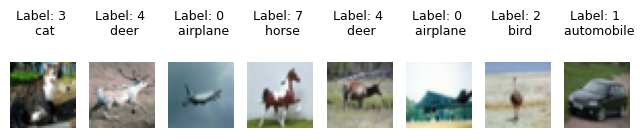

In [6]:
# Define function for showing images and labels
def show_cifar_images(images, labels, class_names, figsize=(8, 8)):
    n_col = len(images)
    fig, axes = plt.subplots(1, n_col, figsize=figsize)

    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        if i < n_col:
            ax.axis('off')
            label = labels[i].item()
            image = (images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
            ax.imshow(image)
            title = f'Label: {label} \n {class_names[label]}'
            ax.set_title(title, pad=20, fontsize=9)

    plt.show()

# Define a list of class names for CIFAR-10
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer",
                      "dog", "frog", "horse", "ship", "truck"]

# Displaying CIFAR-10 training images and labels
images, labels = next(iter(train_loader))
show_cifar_images(images[:8], labels[:8], cifar10_class_names)

# Model: Deterministic Neural Net






## Deterministic Net

Network architecture from https://arxiv.org/abs/1412.6806

In [7]:
class DeterministicNet(nn.Module):
    def __init__(self):
        super(DeterministicNet, self).__init__()

        # 3x3 conv 1
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, padding="same", bias = False)
        self.bn1 = nn.BatchNorm2d(96)

        # 3x3 conv 2
        self.conv2 = nn.Conv2d(96, 96, kernel_size=3, padding="same", bias = False)
        self.bn2 = nn.BatchNorm2d(96)

        # 3x3 conv 3
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, padding="same", bias = False)
        self.bn3 = nn.BatchNorm2d(192)

        # 3x3 conv 4
        self.conv4 = nn.Conv2d(192, 192, kernel_size=3, padding="same", bias = False)
        self.bn4 = nn.BatchNorm2d(192)

        # 3x3 conv 5
        self.conv5 = nn.Conv2d(192, 192, kernel_size=3, padding="same", bias = False)
        self.bn5 = nn.BatchNorm2d(192)

        # 1x1 conv 6
        self.conv6 = nn.Conv2d(192, 192, kernel_size=1, padding="same", bias = False)
        self.bn6 = nn.BatchNorm2d(192)

        # 1x1 conv 7
        self.conv7 = nn.Conv2d(192, 10, kernel_size=1, padding="same", bias = False)
        self.bn7 = nn.BatchNorm2d(10)

    def forward(self, x):

        # 3x3 conv 1
        x = self.conv1(x)
        x = F.relu(self.bn1(x))

        # 3x3 conv 2
        x = self.conv2(x)
        x = F.relu(self.bn2(x))

        # 3x3 max-pooling stride 2
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        # 3x3 conv 3
        x = self.conv3(x)
        x = F.relu(self.bn3(x))

        # 3x3 conv 4
        x = self.conv4(x)
        x = F.relu(self.bn4(x))

        # 3x3 conv 5
        x = self.conv5(x)
        x = F.relu(self.bn5(x))

        # 1x1 conv 6
        x = self.conv6(x)
        x = F.relu(self.bn6(x))

        # 1x1 conv 7
        x = self.conv7(x)
        x = F.relu(self.bn7(x))

        # Average pooling
        x = torch.mean(x, dim = (-2,-1))

        # 10-way softmax
        x = F.log_softmax(x, dim=1)

        return x

## Training

In [11]:
# Create and train the network
def train_deterministic_model():

    model = DeterministicNet().to(device)
    criterion = nn.NLLLoss()

    # Separate weight and bias parameters from others for weight decay
    weight_decay_params = []
    other_params = []

    for name, param in model.named_parameters():
        if 'bias' or 'weight' in name:
            weight_decay_params.append(param)
        else:
            other_params.append(param)

    optimizer = optim.SGD([
        {'params': weight_decay_params, 'weight_decay': 1e-4}, # Apply weight decay to weights
        {'params': other_params, 'weight_decay': 0} # Exclude weight decay for batch normalization
    ], lr=0.05)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    train_epochs = 70

    for epoch in range(train_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          data_likelihood = criterion(outputs, labels)
          loss = data_likelihood
          loss.backward()
          optimizer.step()
        scheduler.step()
        print(f'Epoch [{epoch+1}/{train_epochs}], Train loss: {loss.item()}')
    return model

# Evaluation

- Accuracy

- Negative log likelihood (NLL)

- Expected calibration error (ECE)


In [12]:
def test_deterministic_model():

    # Load the trained deterministic model
    model = DeterministicNet().to(device)
    model.load_state_dict(torch.load('deterministic_model.pth', map_location = device))
    model.eval()

    test_size = len(test_loader.dataset)
    correct_predictions = 0
    negative_log_likelihood = 0
    expected_calibration_error = 0

    with torch.no_grad():

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)

            probabilities = torch.exp(output)
            predictions = output.max(1, keepdim = False)[1] # Index 1 takes the indices of max # index of max log-probability

            correct_predictions += predictions.eq(labels.view_as(predictions)).cpu().numpy() # squeeze the tensor, move it to CPU, and convert to a NumPy array
            negative_log_likelihood += nn.NLLLoss(reduction = "sum")(output, labels)
            expected_calibration_error += MulticlassCalibrationError(num_classes = 10, n_bins = 15, norm = "l1")(probabilities, labels)

    accuracy = correct_predictions.sum()/test_size
    nll = negative_log_likelihood.item()/test_size
    ece = expected_calibration_error.item()/test_size

    print(f"Accuracy: {accuracy}")
    print(f"Negative log likelihood: {nll}")
    print(f"Expected Calibration Error (ECE): {ece}")

    return accuracy, nll, ece

# Running Training and Testing with Different Seeds

In [13]:
seeds = [0,1,2]
accuracies = []
nlls = []
eces = []

for i, seed in enumerate(seeds):
  random.seed(seed)

  # Printing training loss for each epoch and training duration
  print(f"----- Seed {i+1} -------")
  start_time = time.time()
  print("Training started at:", time.ctime())

  model = train_deterministic_model()
  end_time = time.time()
  print("Training ended at:", time.ctime())
  print("Training took", end_time - start_time, "seconds")
  torch.save(model.state_dict(), 'deterministic_model.pth')

  accuracy, nll, ece = test_deterministic_model()
  accuracies.append(accuracy)
  nlls.append(nll)
  eces.append(ece)

print("----------------")
print("Mean accuracy:", np.mean(accuracies))
print("Mean nll:", np.mean(nlls))
print("Mean ece:", np.mean(eces))

----- Seed 1 -------
Training started at: Sun Jan 14 11:05:16 2024
Epoch [1/70], Train loss: 1.3816136121749878
Epoch [2/70], Train loss: 1.033793568611145
Epoch [3/70], Train loss: 0.7913357615470886
Epoch [4/70], Train loss: 0.692950963973999
Epoch [5/70], Train loss: 0.648648202419281
Epoch [6/70], Train loss: 0.6587892770767212
Epoch [7/70], Train loss: 0.5611612200737
Epoch [8/70], Train loss: 0.5592714548110962
Epoch [9/70], Train loss: 0.4755810499191284
Epoch [10/70], Train loss: 0.31210774183273315
Epoch [11/70], Train loss: 0.4388936161994934
Epoch [12/70], Train loss: 0.4702413082122803
Epoch [13/70], Train loss: 0.3686966300010681
Epoch [14/70], Train loss: 0.32036811113357544
Epoch [15/70], Train loss: 0.29752427339553833
Epoch [16/70], Train loss: 0.2041037380695343
Epoch [17/70], Train loss: 0.2430827021598816
Epoch [18/70], Train loss: 0.22938667237758636
Epoch [19/70], Train loss: 0.27672022581100464
Epoch [20/70], Train loss: 0.21396420896053314
Epoch [21/70], Train l